In [1]:
# Import Packages
import pandas as pd
import numpy  as np
import math as math
import datetime
import time
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from pandas.api.types import CategoricalDtype
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot
from statsmodels.tools.eval_measures import rmse

In [2]:
# Define useful functions
def compress_dataframe(dataframe):

    start = time.time()
    
    print('Dataframe was {:.2f} MB'.format(startingMemoryUsage))

    for column in dataframe.columns:
        columnDataType = dataframe[column].dtype
        
        if column == 'timestamp':
            dataframe[column] = pd.to_datetime(dataframe[column], format='%Y-%m-%d %H:%M:%S')
        
        elif columnDataType != object:
            columnMin = dataframe[column].min()
            columnMax = dataframe[column].max()

            if str(columnDataType)[:3] == 'int':
                if columnMin > np.iinfo(np.int8).min and columnMax < np.iinfo(np.int8).max:
                    dataframe[column] = dataframe[column].astype(np.int8)
                elif columnMin > np.iinfo(np.int16).min and columnMax < np.iinfo(np.int16).max:
                    dataframe[column] = dataframe[column].astype(np.int16)
                elif columnMin > np.iinfo(np.int32).min and columnMax < np.iinfo(np.int32).max:
                    dataframe[column] = dataframe[column].astype(np.int32)
                elif columnMin > np.iinfo(np.int64).min and columnMax < np.iinfo(np.int64).max:
                    dataframe[column] = dataframe[column].astype(np.int64)  
            else:
                if columnMin > np.finfo(np.float16).min and columnMax < np.finfo(np.float16).max:
                    dataframe[column] = dataframe[column].astype(np.float16)
                elif columnMin > np.finfo(np.float32).min and columnMax < np.finfo(np.float32).max:
                    dataframe[column] = dataframe[column].astype(np.float32)
                else:
                    dataframe[column] = dataframe[column].astype(np.float64)
        else:
            dataframe[column] = dataframe[column].astype('category')

    endingingMemoryUsage = dataframe.memory_usage().sum() / 1024**2

    print('Dataframe is now: {:.2f} MB'.format(endingingMemoryUsage))
    
    print("Time to reduce dataframe size:",round((time.time()-start)/60, 2), 'minutes.')

In [3]:
# Given a building_id, a meter type, and a date range, plot the energy use

def plotData(df, building_id, meter, name, start_day, end_day):
  
    df_plt = df[(df['building_id'] == building_id) & (df['meter'] == meter)]
    df_plt = df_plt[(df_plt['timestamp'] > start_day) & (df_plt['timestamp'] < end_day)]
    
    plt.figure(figsize=(20,2))
    plt.plot(df_plt['timestamp'], df_plt['meter_reading'])
    plt.xlabel('Time')
    plt.ylabel('Meter Reading')
    plt.title(name)
    plt.show()

In [4]:
# Given a zone_id and a date range, plot the weather

def plotWeather(df, zone_id, name, start_day, end_day, parameter):

    df_plt = df[df['site_id'] == zone_id]
    df_plt = df_plt[(df_plt['timestamp'] > start_day) & (df_plt['timestamp'] < end_day)]
    
    plt.figure(figsize=(20,2))
    plt.plot(df_plt['timestamp'], df_plt[parameter])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(name)
    plt.show()

In [5]:
# Given a building_id, plot energy use (all three meters, if available) and weather data

def display_energy_use(df, building_id, start_day, end_day):

    print("Displaying data for Building", building_id, "between:", start_day, "and", end_day, '\n')
    
    print("Building's primary use:", df.loc[df['building_id'] == building_id, 'primary_use'].iloc[0])
    
    print("Building size:", df.loc[df['building_id'] == building_id, 'square_feet'].iloc[0], 'square feet')
      
    for meter_type in df[df['building_id'] == building_id].groupby('meter').meter.unique():
        if(meter_type == elec_meter):
            plotData(df, building_id, elec_meter, "Electricity Meter Data", start_day, end_day)
        if(meter_type == chw_meter):
            plotData(df, building_id, chw_meter,"Chilled Water Meter Data", start_day, end_day)
        if(meter_type == steam_meter):
            plotData(df, building_id, steam_meter, "Steam Meter Data", start_day, end_day)
        if(meter_type == hw_meter):
            plotData(df, building_id,hw_meter, "Hot Water Meter Data", start_day, end_day)            
            
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Air Temperature", start_day, end_day, 'air_temperature')
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Cloud Coverage", start_day, end_day, 'cloud_coverage')
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Dewpoint Temperature", start_day, end_day, 'dew_temperature')
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Precipitation Depth", start_day, end_day, 'precip_depth_1_hr')
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Sea Level Pressure", start_day, end_day, 'sea_level_pressure')
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Wind Direction", start_day, end_day, 'wind_direction')
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Wind Speed", start_day, end_day, 'wind_speed')

In [6]:
# Define useful contants
elec_meter = 0
chw_meter = 1
steam_meter = 2
hw_meter = 3

In [7]:
start = time.time()

df = pd.read_csv('train.csv', sep=',', low_memory=False)

print('Time to read the CSV file into a dataframe: ',round((time.time()-start), 2), 'seconds \n')

startingMemoryUsage = df.memory_usage().sum() / 1024**2

print('Dataframe size is {:.2f} MB'.format(startingMemoryUsage))

Time to read the CSV file into a dataframe:  20.18 seconds 

Dataframe size is 616.95 MB


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [9]:
df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [10]:
compress_dataframe(df)

Dataframe was 616.95 MB
Dataframe is now: 289.19 MB
Time to reduce dataframe size: 0.1 minutes.


In [11]:
start = time.time()

df_weather = pd.read_csv('weather_train.csv', sep=',', low_memory=False)

print('Time to read the CSV file into a dataframe: ',round((time.time()-start), 2), 'seconds \n')

startingMemoryUsage = df_weather.memory_usage().sum() / 1024**2

print('Dataframe size is {:.2f} MB'.format(startingMemoryUsage))

Time to read the CSV file into a dataframe:  0.26 seconds 

Dataframe size is 9.60 MB


In [12]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [13]:
df_weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [14]:
compress_dataframe(df_weather)

Dataframe was 9.60 MB
Dataframe is now: 3.07 MB
Time to reduce dataframe size: 0.0 minutes.


In [15]:
tart = time.time()

df_building_metadata = pd.read_csv(filepath_or_buffer='building_metadata.csv', sep=',', low_memory=False)

print('Time to read the CSV file into a dataframe: ',round((time.time()-start), 2), 'seconds \n')

startingMemoryUsage = df_weather.memory_usage().sum() / 1024**2

print('Dataframe size is {:.2f} MB'.format(startingMemoryUsage))

Time to read the CSV file into a dataframe:  0.55 seconds 

Dataframe size is 3.07 MB


In [16]:
df_building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [17]:
df_building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [18]:
compress_dataframe(df_building_metadata)

Dataframe was 3.07 MB
Dataframe is now: 0.02 MB
Time to reduce dataframe size: 0.0 minutes.


In [19]:
# CLeaning the Dataset

# Checking for duplicate rows

df[df.duplicated()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 4 columns):
building_id      0 non-null int16
meter            0 non-null int8
timestamp        0 non-null datetime64[ns]
meter_reading    0 non-null float32
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 0.0 bytes


In [20]:
# Show how many nulls there are in the main dataset (expressed as a percentage)
print(round(df.isna().sum().sort_values(ascending=False) / len(df.index) * 100, 3))

meter_reading    0.0
timestamp        0.0
meter            0.0
building_id      0.0
dtype: float64


In [21]:
# Show how many nulls there are in the weather dataset (expressed as a percentage)
print(round(df_weather.isna().sum().sort_values(ascending=False) / len(df_weather.index) * 100, 3))

cloud_coverage        49.490
precip_depth_1_hr     35.979
sea_level_pressure     7.597
wind_direction         4.484
wind_speed             0.217
dew_temperature        0.081
air_temperature        0.039
timestamp              0.000
site_id                0.000
dtype: float64


In [22]:
# we have to be careful with this step because 2 close registers  could have very distinct behaviors

# Fill nulls with linear interpolation
df_weather = df_weather.interpolate()
df_weather = df_weather.fillna(0)

# Double check how many nulls are in the feature (should be 0 now)
print(round(df_weather.isna().sum().sort_values(ascending=False) / len(df_weather.index) * 100, 3))

wind_speed            0.0
wind_direction        0.0
sea_level_pressure    0.0
precip_depth_1_hr     0.0
dew_temperature       0.0
cloud_coverage        0.0
air_temperature       0.0
timestamp             0.0
site_id               0.0
dtype: float64


In [23]:
# Show how many nulls there are in the metadata dataset (expressed as a percentage)
print(round(df_building_metadata.isna().sum().sort_values(ascending=False) / len(df_building_metadata.index) * 100, 3))

floor_count    75.500
year_built     53.416
square_feet     0.000
primary_use     0.000
building_id     0.000
site_id         0.000
dtype: float64


In [24]:
# count the number of different building types in the dataset
# df_building_metadata['primary_use'].value_counts()

# filter out the data that relates to office buildings



df_building_metadata = df_building_metadata[df_building_metadata['primary_use'] == 'Office']

# merge this data with the main dataframe, so that we only have meter readings for office buildings
df = df.merge(df_building_metadata, on='building_id', how='inner')

# merge weather data with the main dataframe, so that all the information is in one place
df = df.merge(df_weather, on=['site_id', 'timestamp'], how='inner')

# check dataframe
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,9,0,2016-01-01,0.0,0,Office,27000,2010.0,NaN,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
1,15,0,2016-01-01,0.0,0,Office,83957,1974.0,NaN,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
2,17,0,2016-01-01,0.0,0,Office,15250,1980.0,NaN,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
3,19,0,2016-01-01,0.0,0,Office,18717,2004.0,NaN,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
4,21,0,2016-01-01,0.0,0,Office,7043,1990.0,NaN,25.0,6.0,20.0,0.0,1019.5,0.0,0.0


In [25]:
print(round(df.isna().sum().sort_values(ascending=False) / len(df.index) * 100, 3))

floor_count           91.875
year_built            75.699
wind_speed             0.000
wind_direction         0.000
sea_level_pressure     0.000
precip_depth_1_hr      0.000
dew_temperature        0.000
cloud_coverage         0.000
air_temperature        0.000
square_feet            0.000
primary_use            0.000
site_id                0.000
meter_reading          0.000
timestamp              0.000
meter                  0.000
building_id            0.000
dtype: float64


In [26]:
# There's no great way to fill the floor_count and year_built columns
# Since there are a large number of nulls in the floor_count and year_built features, we will drop these columns

df = df.drop('floor_count', axis=1)
df = df.drop('year_built', axis=1)

df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,9,0,2016-01-01,0.0,0,Office,27000,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
1,15,0,2016-01-01,0.0,0,Office,83957,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
2,17,0,2016-01-01,0.0,0,Office,15250,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
3,19,0,2016-01-01,0.0,0,Office,18717,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
4,21,0,2016-01-01,0.0,0,Office,7043,25.0,6.0,20.0,0.0,1019.5,0.0,0.0


## 3.5 - USE THIS SECTION TO VIEW METER DATA AND WEATHER DATA TOGETHER

Displaying data for Building 9 between: 2016-07-01 and 2016-07-02 

Building's primary use: Office
Building size: 27000 square feet


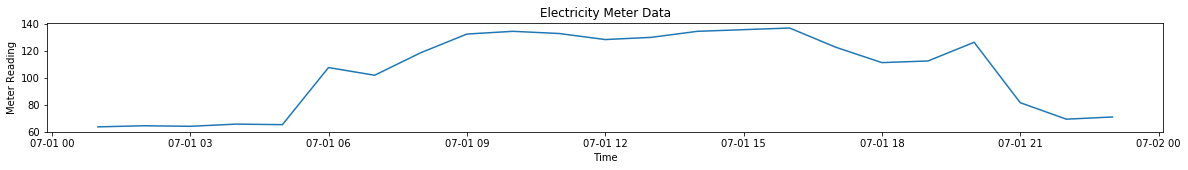

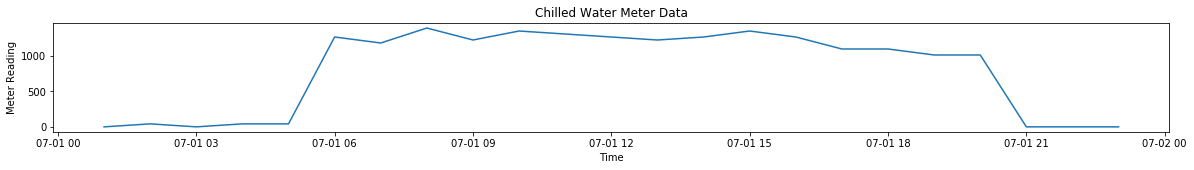

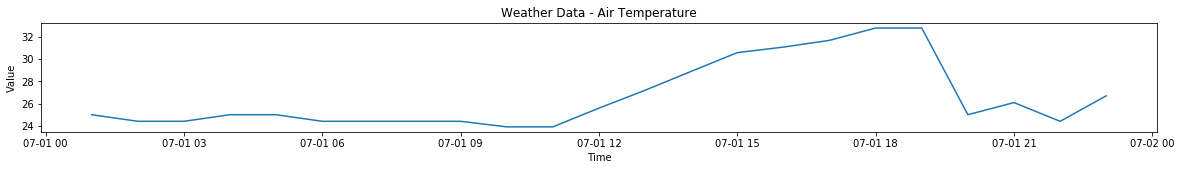

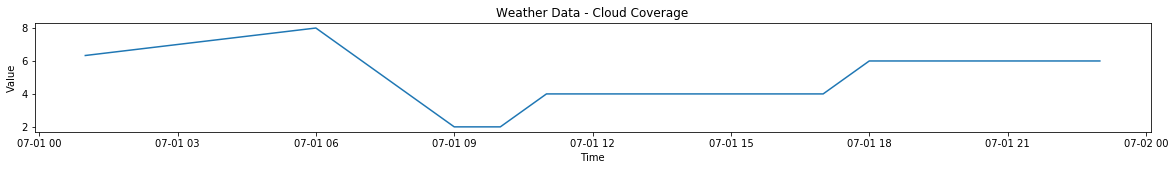

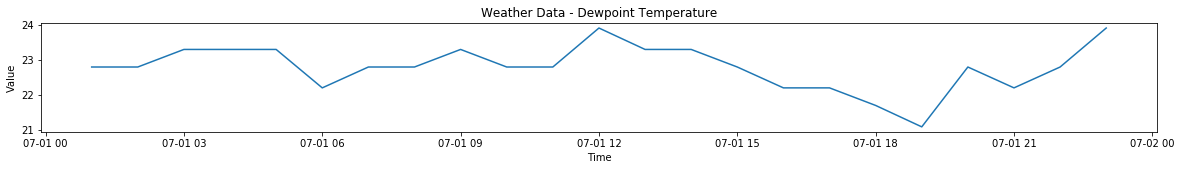

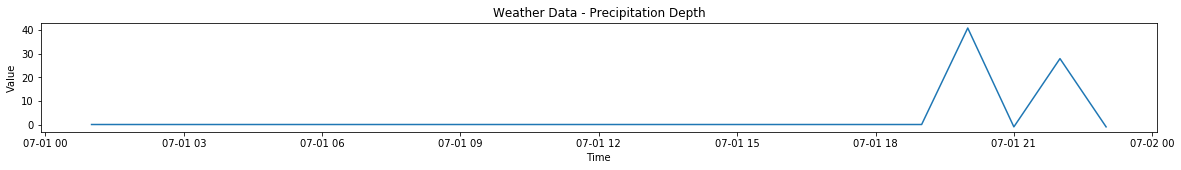

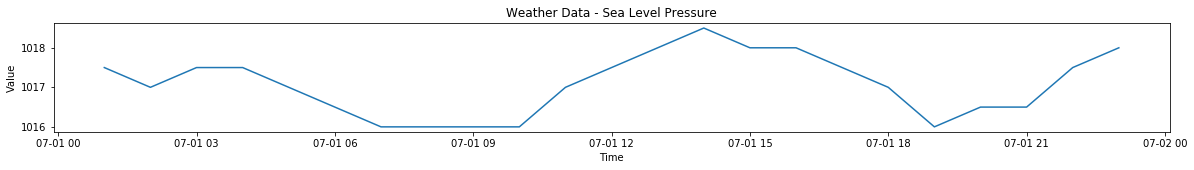

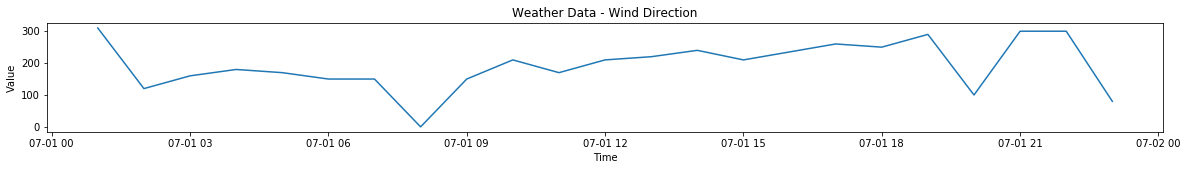

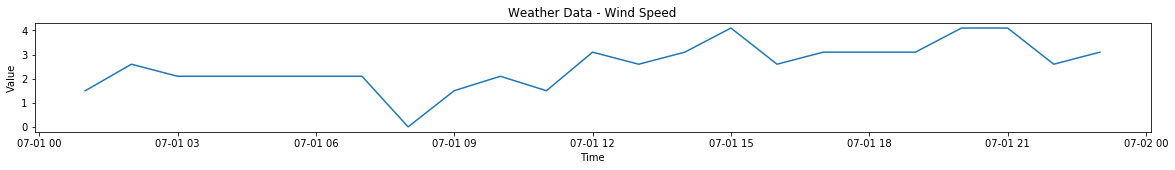

In [27]:
# Change the building_id, the start date, and the end date. This will plot everything, in increments of days

# --------------------------#
building = 9
start_day = "2016-07-01"
end_day = "2016-07-02"
# --------------------------#

if building in df['building_id'].unique():
    display_energy_use(df, building, start_day, end_day)

In [28]:
# Variable Selection portion

print(df['primary_use'].describe())

# We can see that the Primary Use column, has only a single unique value (Office).

# This is the result of the data cleaning phase, that resulted in extracting the results for the office buildings only.

# To that end, this feature is not very useful for us, since all rows represent the Office Buildings data, and we can remove it
# from the Data Set:

df = df.drop(['primary_use'], axis=1)

count     4379290
unique          1
top        Office
freq      4379290
Name: primary_use, dtype: object


## 4.2 - EXAMINE ENERGY CONSUMPTION OVER THE YEAR:

In [29]:
# First, let's transform the meter column s.t. it has actual energy type name as opposed to different numbers. This will make
# the Data Set more clear.

# Every row in the column has a different number representing the different energy type:

# 0 - electricity
# 1 - chilledwater
# 2 - steam
# 3 - hotwater

df['meter'].replace( { 0: 'Electricity', 1: 'ChilledWater' ,2: 'Steam', 3: 'HotWater' }, inplace=True )


# Now, examine the timestamp column:

print(df['timestamp'].head(10))

# Extract the year from each timestamp:

df['year'] = df['timestamp'].dt.year.astype('uint8')

# Examine the different years for which the data was collected:

print('The number of different years the data was collected for: ' + str(df['year'].nunique()))

# Based on our findings, we can see that the data was collected for the year of 2016 only. Thus, we will extract the different
# month values from each timestamp, and drop the 'year' column, as it is not very useful for us:

df = df.drop(['year'], axis=1)

# Extract the month column:

df['month'] = df['timestamp'].dt.month.astype('uint8')

# Examine the month column:

print('The number of different months the data was collected for: ' + str(df['month'].nunique()))

0   2016-01-01
1   2016-01-01
2   2016-01-01
3   2016-01-01
4   2016-01-01
5   2016-01-01
6   2016-01-01
7   2016-01-01
8   2016-01-01
9   2016-01-01
Name: timestamp, dtype: datetime64[ns]
The number of different years the data was collected for: 1
The number of different months the data was collected for: 12


Text(0, 0.5, 'Frequency')

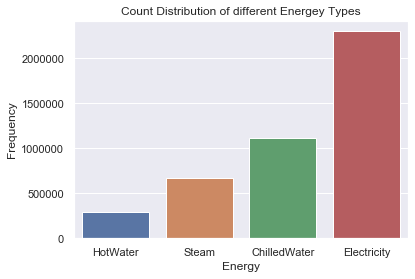

In [30]:

# Count the frequency of different types of energy in the Data Set using the countplot graph:

sns.set()
sns.countplot(df['meter'],order=df['meter'].value_counts().sort_values().index)
plt.title("Count Distribution of different Energey Types")
plt.xlabel("Energy")
plt.ylabel("Frequency")

# Based on our countplot, we can see that Electricity has the highest frequency, followed by ChilledWater.
# Steam has lower frequency than the two above, and HotWater has the lowest.

In [31]:

# Check how the energy consumption is distributed for the different energy types:

df.groupby('meter')['meter_reading'].agg(['min','max','mean','median','count','std'])

# Based on our findings, we can see that Steam has a much higher consumption as opposed to the other energy types.

,min,max,mean,median,count,std
meter,,,,,,
ChilledWater,0.0,25495.599609,284.200104,61.308800,1112229,576.393860
Electricity,0.0,44336.500000,157.653229,64.000000,2303448,296.658661
HotWater,0.0,12100.000000,245.124115,79.129204,289467,405.424164
Steam,0.0,131625.000000,2314.537842,399.843506,674146,8310.513672


Text(0.5, 1.0, 'Graph of Averagy Energy Consumption throughout the year: ')

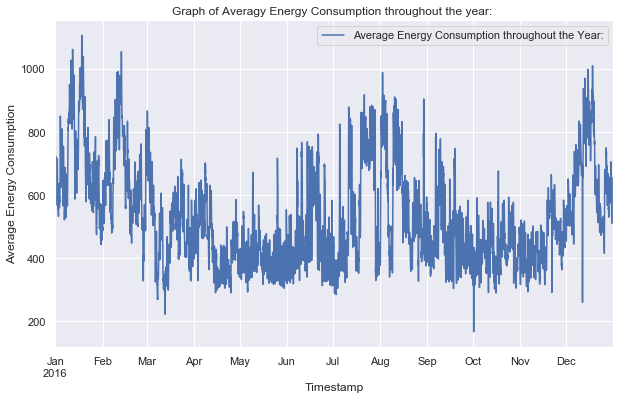

In [32]:
# Draw a plot to see any trends in energy consumption throughout the year:

df[['timestamp','meter_reading']].set_index('timestamp').resample('H')['meter_reading'].mean().plot(kind='line',figsize=(10,6),label='Average Energy Consumption throughout the Year:')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Average Energy Consumption')
plt.title('Graph of Averagy Energy Consumption throughout the year: ')

# Based on our graph, we can see that the energy consumption is the highest in the months of January-February, July-August,
# and on the month of December.

In [33]:

# Examine the energy consumption throughout the year for each energy type:

# Define a function to plot the average energy consumption for individual energent:
def consumption_grapher(meter_value):
    energy_type = df[df['meter'] == meter_value]
    energy_type[['timestamp','meter_reading']].set_index('timestamp').resample('H')['meter_reading'].mean().plot(kind='line',figsize=(10,6),label='Average Meter Reading')
    plt.legend()
    plt.xlabel('Timestamp')
    plt.ylabel('Average Meter Reading')
    plt.title('Graph of Average Meter Reading for ' + meter_value)

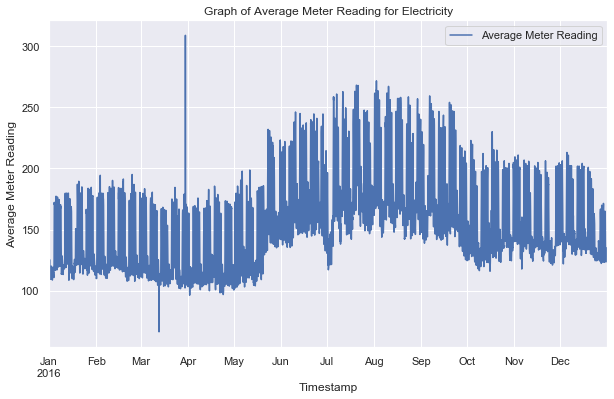

In [34]:
# Examine the Electricity Consumption throughout the year:

consumption_grapher('Electricity')

# We can see that the Electricity consumption generally increases throughout the year until the month of October, when it
# starts decreasing for the rest of the year.

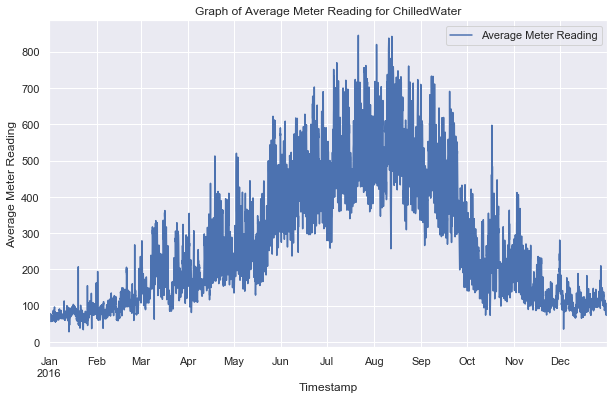

In [35]:
# Examine the ChilledWater consumption throughout the year:

consumption_grapher('ChilledWater')

# We can see a large increase in ChilledWater consumption from the months of January-August when it is the highest.
# The consumption then starts dropping, and records the lowest values in the month of December.

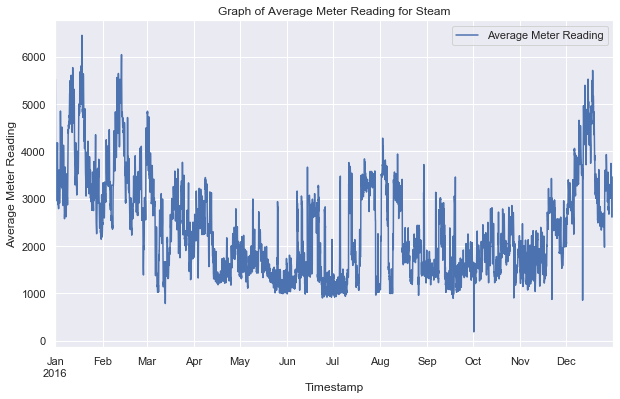

In [36]:
# Examine the Steam consumption throughout the year:

consumption_grapher('Steam')

# We can see that the Steam consumption generally follows the similar trend as the trend of all energy types combined.

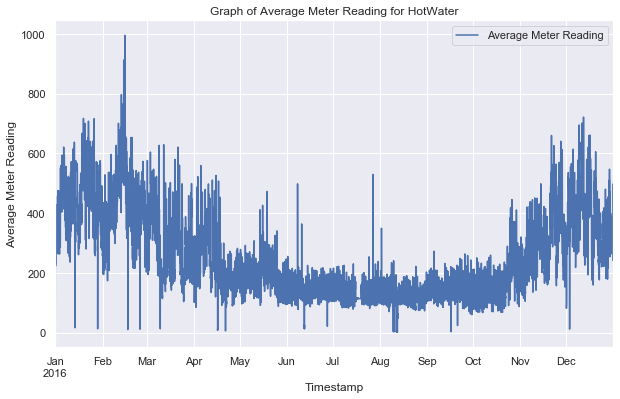

In [37]:
# Examine the HotWater consumption throughout the year:

consumption_grapher('HotWater')

# We can see that the HotWater consumption also follows the similar trend to the trend of all energy types combined.

In [38]:
# Use groupby to calculate the min, max, median, count, and std values for each energent for each different month:

df.groupby(['meter','month'])['meter_reading'].agg(['max','mean','median','count','std'])

# Based on our findings, we can see that the Steam consumption is generally a lot higher than that of the other energy types
# for the different months, and has lower counts.

max         mean      median   count  \
meter        month                                                   
ChilledWater 1        8617.480469    75.833519    6.540000   86840   
             2        9769.349609   102.494522   14.547350   75912   
             3        8718.750000   184.390152   31.933001   86055   
             4        7152.339844   225.738083   42.483002   94418   
             5        7278.419922   311.845825   96.431999   98020   
             6        7618.859863   453.126801  165.934006   94360   
             7        7495.640137   528.540161  198.421005   98049   
             8        7625.680176   553.814880  214.746994   94208   
             9        6954.120117   433.723236  137.781006   94224   
             10      25495.599609   215.689713   44.648800   98104   
             11       7460.939941   153.882019   28.220699   94203   
             12       5109.470215   109.408806   11.359400   97836   
Electricity  1        2953.070068   137.190063   55.404999  196755   
             2        3170.000000   139.905563   56.500000  176925   
             3       44336.500000   132.392487   53.466599  184942   
             4        2603.409912   129.073166   53.685001  189673   
             5        3828.239990   147.596130   59.000000  196584   
             6        4588.500000   180.549210   73.328506  189504   
             7        4758.750000   184.486740   72.078400  196567   
             8        4854.729980   192.931107   75.905350  195988   
             9        6836.919922   179.549820   74.720001  192221   
             10       4502.450195   156.149918   63.000000  197816   
             11       3095.439941   155.609879   67.983002  191150   
             12       2876.879883   153.493027   66.320000  195323   
HotWater     1        6545.779785   440.043823  212.455002   24527   
             2        9486.269531   419.266663  219.893494   22934   
             3        7020.279785   277.973480  140.300995   24482   
             4        6435.520020   223.666794   94.023102   23751   
             5        4584.919922   189.531479   56.166298   24498   
             6       10803.200195   153.059326   12.482950   23610   
             7       12100.000000   139.918213    8.792100   24540   
             8        6700.000000   132.136368    2.930700   24533   
             9        1998.280029   152.514130   12.106400   23755   
             10       4378.899902   162.969208   10.000000   24549   
             11       5694.029785   294.588226  100.209999   23747   
             12       7304.399902   361.754272  134.813004   24541   
Steam        1      104250.000000  3705.746338  909.114502   57682   
             2       91500.000000  3456.838867  839.190979   49277   
             3       75750.000000  2395.896973  554.687988   50384   
             4       62250.000000  1960.548584  419.832001   56724   
             5       93750.000000  1538.504150  250.494995   58425   
             6      126000.000000  1677.720703  186.511002   56201   
             7      126750.000000  2087.276123  145.488998   58429   
             8      131625.000000  2247.189453  156.692993   58114   
             9      105000.000000  1657.392822  199.632996   56657   
             10      74250.000000  1796.131836  253.269989   58430   
             11      64125.000000  1932.576172  502.007019   56672   
             12     108000.000000  3485.726074  976.562012   57151   

                             std  
meter        month                
ChilledWater 1        203.830872  
             2        251.447952  
             3        398.356171  
             4        451.647949  
             5        554.798706  
             6        703.998474  
             7        806.363586  
             8        854.131409  
             9        726.865295  
             10       438.712097  
             11       336.498535  
             12       309.374756  
Electricity  1        265.122101  
    

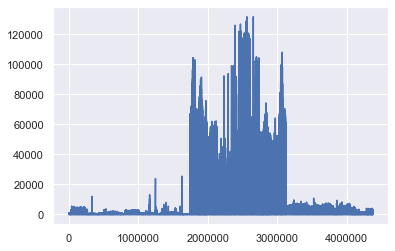

,building_id,meter,timestamp,meter_reading,site_id,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month
0,9,Electricity,2016-01-01 00:00:00,0.000000,0,27000,25.000000,6.0,20.000000,0.0,1019.5,0.0,0.000000,1
1,15,Electricity,2016-01-01 00:00:00,0.000000,0,83957,25.000000,6.0,20.000000,0.0,1019.5,0.0,0.000000,1
2,17,Electricity,2016-01-01 00:00:00,0.000000,0,15250,25.000000,6.0,20.000000,0.0,1019.5,0.0,0.000000,1
3,19,Electricity,2016-01-01 00:00:00,0.000000,0,18717,25.000000,6.0,20.000000,0.0,1019.5,0.0,0.000000,1
4,21,Electricity,2016-01-01 00:00:00,0.000000,0,7043,25.000000,6.0,20.000000,0.0,1019.5,0.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4379285,1387,Steam,2016-12-31 23:00:00,967.830994,15,187041,1.700195,2.0,-5.601562,-1.0,1008.5,180.0,8.796875,12
4379286,1410,Electricity,2016-12-31 23:00:00,5.650000,15,11524,1.700195,2.0,-5.601562,-1.0,1008.5,180.0,8.796875,12
4379287,1410,ChilledWater,2016-12-31 23:00:00,16.700001,15,11524,1.700195,2.0,-5.601562,-1.0,1008.5,180.0,8.796875,12
4379288,1430,Steam,2016-12-31 23:00:00,318.567993,15,53303,1.700195,2.0,-5.601562,-1.0,1008.5,180.0,8.796875,12


In [39]:

plt.plot(df['meter_reading'])

plt.show()

df

Text(0.5, 1.0, 'Distribution of Log-transformed of Meter Reading Variable')

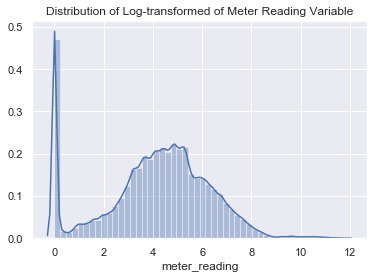

In [40]:

# Since we cannot see any clear distribution in the energy consumption, we will transform the meter_reading using
# log transformation:

df['meter_reading'] = np.log1p(df['meter_reading'])

# Use the distribution plot to see how the log-transformed energy consumption is distributed:

sns.distplot(df['meter_reading'])
plt.title("Distribution of Log-transformed of Meter Reading Variable")

# Based on the graph we can see that the log-transformed energy consumption follows a nearly normal distribution, however
# it seems to have a lot of 0-value outliers.

In [41]:
# Examine the outliers using the Box Plot graphs:

energy_types = [ 'Electricity', 'ChilledWater', 'HotWater', 'Steam' ]

def boxplot_grapher(meter_type):
    sns.boxplot(df[df['meter'] == meter_type]['meter_reading'])
    plt.title('Boxplot of Meter Reading Variable for the Meter Type: ' + meter_type)

# Based on our Box Plots, we can see that there are a lot of 0-valued outliers, and that Electricity has the outliers in
# values greater than 8.

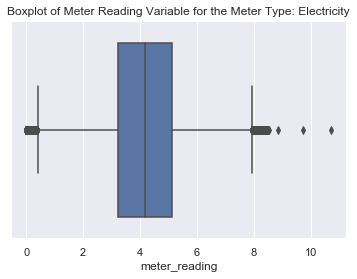

In [42]:
boxplot_grapher('Electricity')

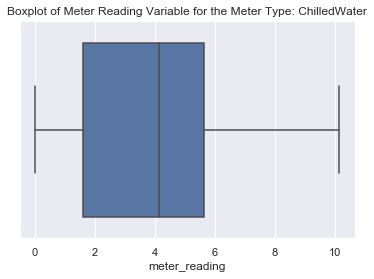

In [43]:
boxplot_grapher('ChilledWater')

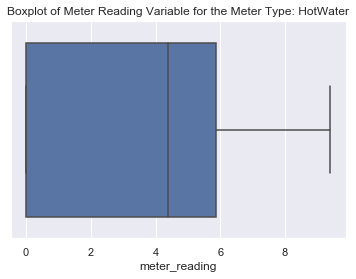

In [44]:
boxplot_grapher('HotWater')

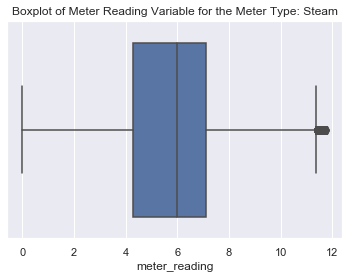

In [45]:
boxplot_grapher('Steam')

In [46]:
# Based on our findings, we can determine the following:

# 1) Despite a relatively low count, the Energy Consumption of Steam is much higher than that of the other Energy Types,
#    to the extend where it dictates the trends in the energy consumption. To that end we will remove it from the Data Set.

# 2) The Data Set appears to have a lot of 0-valued outliers, and we will be removing these:

# Remove the 0-valued outliers:
df.drop(df.loc[(df['meter'] == 'Electricity') & (df['meter_reading'] == 0)].index, inplace=True)
df.drop(df.loc[(df['meter'] == 'HotWater') & (df['meter_reading'] == 0)].index, inplace=True)
df.drop(df.loc[(df['meter'] == 'ChilledWater') & (df['meter_reading'] == 0)].index, inplace=True)

# Remove the outliers from Electricity with values greater than 8:
df.drop(df.loc[(df['meter'] == 'Electricity') & (df['meter_reading'] > 8)].index, inplace=True)

In [47]:
# Remove Steam from the Data Set:
df.drop(df.loc[df['meter']=='Steam'].index, inplace=True)

Text(0.5, 1.0, 'Distribution of Log-transformed of Meter Reading Variable')

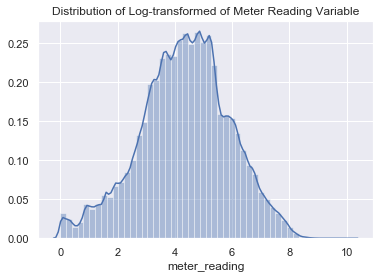

In [48]:
# Examine the Energy Distribution throughout the year after implementing the transformation:

sns.distplot(df['meter_reading'])
plt.title("Distribution of Log-transformed of Meter Reading Variable")

# Based on the graph below, the meter reading now follows the normal distribution.

## 4.3 EXAMINE THE WEATHER FEATURES:

In [49]:
# Define an array to hold the column names of all weather features:
weather_columns = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed', 'wind_direction']

# Examine the weather data:
df[weather_columns].describe()

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,wind_direction
count,3.317678e+06,3317678.0,3.317678e+06,3317678.0,3317678.0,3.317678e+06,3317678.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.000000e+00,0.0,0.000000e+00,NaN,NaN,0.000000e+00,NaN
min,-2.890625e+01,0.0,-3.170312e+01,-1.0,968.0,0.000000e+00,0.0
25%,7.199219e+00,0.0,-6.000977e-01,0.0,1011.5,2.099609e+00,80.0
50%,1.609375e+01,2.0,7.800781e+00,0.0,1016.0,3.099609e+00,180.0
75%,2.329688e+01,5.0,1.560156e+01,0.0,1020.5,4.601562e+00,270.0
max,4.718750e+01,9.0,2.609375e+01,343.0,1046.0,1.900000e+01,360.0


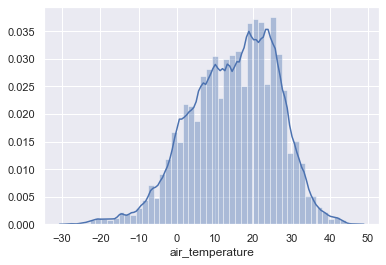

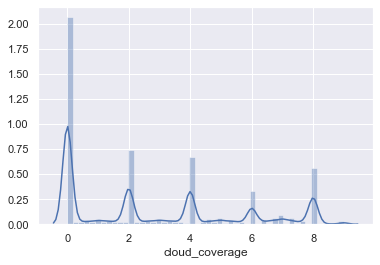

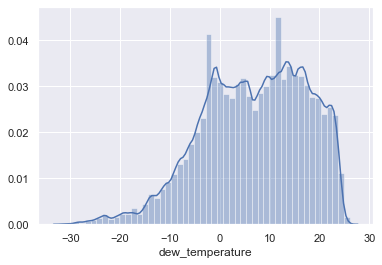

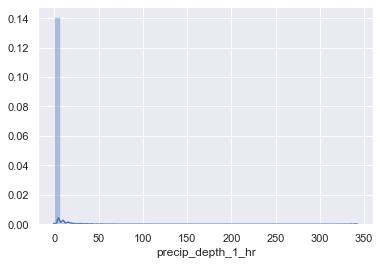

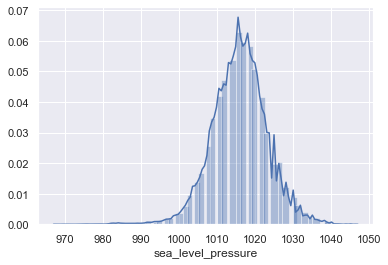

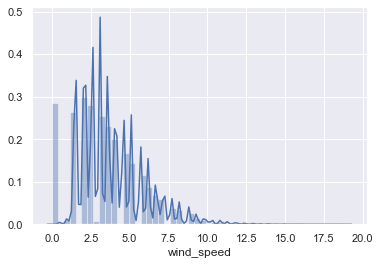

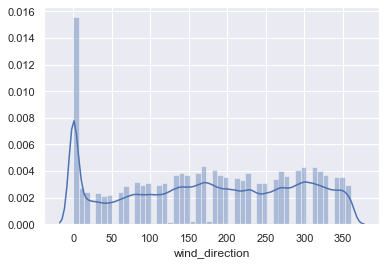

In [50]:
# Use the Distribution Plot to see how the different Weather Features are distributed:

for x,column in enumerate(df[weather_columns]):
    plt.figure(x)
    sns.distplot(df[column])
    
# Based on our findings, we can determine the following:

# air_temperature appears to be positively-skewed.
# cloud_coverage is unique in that it is composed of a number of distinct values.
# dew_temperature appears to be positively-skewed.
# percip_depth_1_hr has a lot of 0 values in the Data Set.
# sea_level_pressure follows the normal distribution.
# wind_speed seems to be negatively skewed.

In [51]:
# Now, we will examine the columns to see if they have a very high level of coordination:

# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = df.corr().abs()
corr_matrix.head()

,building_id,meter_reading,site_id,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month
building_id,1.000000,0.003511,0.985765,0.054891,0.319451,0.047832,0.149581,0.046564,0.065864,0.080965,0.039041,0.039469
meter_reading,0.003511,1.000000,0.015906,0.427622,0.115302,0.014011,0.126175,0.002100,0.003147,0.019434,0.038961,0.010377
site_id,0.985765,0.015906,1.000000,0.062422,0.322829,0.014207,0.167994,0.047000,0.050742,0.090002,0.054921,0.036981
square_feet,0.054891,0.427622,0.062422,1.000000,0.059204,0.146159,0.058809,0.004424,0.004447,0.015500,0.046951,0.017862
air_temperature,0.319451,0.115302,0.322829,0.059204,1.000000,0.035982,0.786166,0.025744,0.284114,0.106327,0.087352,0.184938


In [52]:
# Select the columns with very high levels of correlation to be removed
columns = [column for column in corr_matrix[weather_columns] if any(corr_matrix[column] > threshold)]

print ("Columns with high levels of correlation to be removed {}".format(columns))

# We will keep the sea_level_pressure, as it follows the normal distribution, and can be used for energy prediction:

columns.remove('sea_level_pressure')

Columns with high levels of correlation to be removed ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed', 'wind_direction']


In [53]:
# Based on our findings, the below columns have a very high levels of correlation, and thus can be removed:

# air_temperature
# cloud_coverage
# dew_temperature
# precip_depth_1_hr
# wind_speed


df = df.drop(columns, axis=1)

## 4.4 Examine the Surface Area

In [54]:
df['square_feet'].describe()

count    3.317678e+06
mean     9.306052e+04
std      1.154806e+05
min      2.260000e+03
25%      2.875000e+04
50%      6.009600e+04
75%      1.114240e+05
max      8.615240e+05
Name: square_feet, dtype: float64

Text(0.5, 1.0, "Distribution of Building's Surface Area: ")

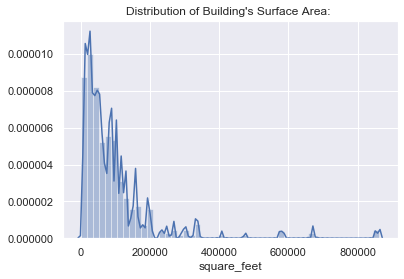

In [55]:
# Use the Distribution Plot to see how the Surface Area is distributed:

sns.distplot(df['square_feet'])
plt.title("Distribution of Building's Surface Area: ")

In [56]:
# The Surface Area seems to be negatively-skewed.

# Let's transform it using the log based 10 transformation:

df['square_feet'] = np.log10(df['square_feet'])

# We can see that after the log-transformation the Surface Area follows an almost Normal Distribution.

Text(0.5, 1.0, "Distribution of Building's Surface Area: ")

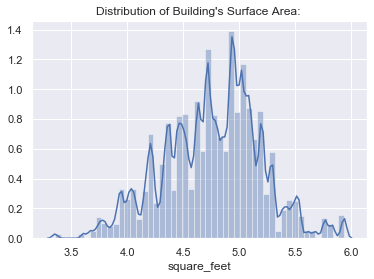

In [57]:
sns.distplot(df['square_feet'])
plt.title("Distribution of Building's Surface Area: ")

## 4.5 REMOVE FEATURES THAT ARE NO LONGER NEEDED

In [58]:
# Now, we can remove the features that are no longer needed:

# The site_id and building_id are used as unique identifiers for buildings and sites they are located, and are thus not very
# useful for predicting energy.

# Likewise, we no longer need the timestamp and time features, as they were used for transforming data.

df = df.drop(['month', 'timestamp', 'site_id', 'building_id'], axis=1)

In [59]:
df.head(10)

,meter,meter_reading,square_feet,sea_level_pressure
19,Electricity,3.978196,4.523356,1019.5
139,Electricity,0.915570,4.523356,1020.0
475,Electricity,4.052063,4.523356,1017.0
779,Electricity,4.023167,4.523356,1018.5
1121,Electricity,6.716360,4.943208,1018.0
1145,Electricity,6.608595,4.943208,1018.0
1169,Electricity,6.291475,4.943208,1018.5
1193,Electricity,6.356089,4.943208,1018.5
1385,Electricity,6.727211,4.943208,1017.0
1409,Electricity,6.722293,4.943208,1017.0


In [60]:
df.columns

Index(['meter', 'meter_reading', 'square_feet', 'sea_level_pressure'], dtype='object')

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3317678 entries, 19 to 4379289
Data columns (total 4 columns):
meter                 object
meter_reading         float32
square_feet           float64
sea_level_pressure    float16
dtypes: float16(1), float32(1), float64(1), object(1)
memory usage: 94.9+ MB


# MODEL FITTING & VALIDATION

## Multiple Linear Regression

Since we have broken down our dataframe into a manageable number of variables, we will make an attempt at fitting a Linear model to the data. Our model equation will be as follows:

$$ Y = b_{0} + b_{1}X_{1} + b_{2}X_{2} + b_{3}X_{3}$$

Where $Y$ is the meter reading, $X_{1}$ is the square footage of the building, $X_{2}$ is the sea level pressure, and $X_{3}$ is the meter category (Electricity, ChilledWater, HotWater). We have $b_{0}$ as our y-intercept while the rest of $b_{i}$ are slope constants.

We also have to deal with the fact that Meter is a categorical variable. As seen below, we will convert our values via polynomial encoding where:

- 1 = Electricity
- 2 = ChilledWater
- 3 = HotWater

In [62]:
df["meter"].value_counts()

Electricity     2183632
ChilledWater     919672
HotWater         214374
Name: meter, dtype: int64

In [63]:
# Convert `meter` to ordianal
meter_cat = CategoricalDtype(categories = ['Electricity', 'ChilledWater', 'HotWater'], ordered = True)
df["meter"] = df["meter"].astype(meter_cat)

We will use a boxplot to depict the associations between the meter reading and meter type.

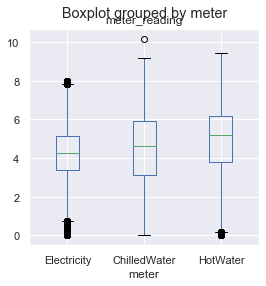

In [64]:
df.boxplot(column="meter_reading", by= "meter", figsize= (4,4))
plt.show()

The boxplot does show that there is some order between the 3 values, with Electricity having the slightly lower mean and HotWater the highest, we will use polynomial encoding to transform the "meter" value in preparation for our model fitting, using this boxplot as reference.

In [76]:
# Mapping the meter types for polynomial encoding
mapper = {'Electricity' : 1, 'ChilledWater' : 2, 'HotWater' : 3}

# Mapping
df['meter_linear'] = df['meter'].map(mapper)
df['meter_linear'] = df['meter_linear'].astype('int32')
df['meter_square'] = df['meter_linear']**2

In [77]:
# Quick Validation Check - now we can move on to fitting the model

print(df["meter_linear"].value_counts())
print(df["meter_square"].value_counts())

1    2183632
2     919672
3     214374
Name: meter_linear, dtype: int64
1    2183632
4     919672
9     214374
Name: meter_square, dtype: int64


In [78]:
# Fitting a linear model with all of our variables involved

model = smf.ols('meter_reading ~ square_feet + sea_level_pressure + meter_linear + meter_square', data=df).fit()
predictions = model.predict(df)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          meter_reading   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                 2.673e+05
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:28:59   Log-Likelihood:            -5.7238e+06
No. Observations:             3317678   AIC:                         1.145e+07
Df Residuals:                 3317673   BIC:                         1.145e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.3814      0.105    -41.648      0.000      -4.588      -4.175
square_feet            1.7575      0.002   1018.356      0.000       1.754       1.761
sea_level_pressure     0.0009      0.000      8.405      0.000       0.001       0.001
meter_linear          -0.8169      0.008   -107.519      0.000      -0.832      -0.802
meter_square           0.2709      0.002    128.608      0.000       0.267       0.275
==============================================================================
Omnibus:                   187360.554   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           257531.267
Skew:                          -0.523   Prob(JB):                         0.00
Kurtosis:                       3.877   Cond. No.                     1.43e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The obtained linear model equation is $ Y = 1.7575X_{1} + 0.0009X_{2} - 0.8169X_{3} + 0.2709X_{4} - 4.3814 $, the $ R^2 $ value is 0.244 meaning that the model can only explain approximately 24.4% of the variability in our meter readings. The p-values for both the F-statistic and the t-statistics are all equal to zero, which tells us that there is definitely a linear association between our response and predictor variables.

As a comparison, we will evaluate the model without the 'meter' variable involved

In [79]:
# Fitting a linear model with the meter variable removed

model_short = smf.ols('meter_reading ~ square_feet + sea_level_pressure', data=df).fit()
model_short.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          meter_reading   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                 5.142e+05
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:49:50   Log-Likelihood:            -5.7392e+06
No. Observations:             3317678   AIC:                         1.148e+07
Df Residuals:                 3317675   BIC:                         1.148e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.8394      0.105    -45.900      0.000      -5.046      -4.633
square_feet            1.7427      0.002   1014.106      0.000       1.739       1.746
sea_level_pressure     0.0009      0.000      8.519      0.000       0.001       0.001
==============================================================================
Omnibus:                   147594.077   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           193317.112
Skew:                          -0.458   Prob(JB):                         0.00
Kurtosis:                       3.748   Cond. No.                     1.43e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It appears that stripping out the meter values only weakens our model (albeit slightly), since the $R^2$  drops, but the p-values remain the same across the board. Suggesting there is a strong association between the meter reading and all of our variables. We will evaluate the residuals using our full model.

In [80]:
df['meter_prediction'] = predictions
df.head()

,meter,meter_reading,square_feet,sea_level_pressure,meter_linear,meter_square,meter_prediction
19,Electricity,3.978196,4.523356,1019.5,1,1,3.904150
139,Electricity,0.915570,4.523356,1020.0,1,1,3.904583
475,Electricity,4.052063,4.523356,1017.0,1,1,3.901988
779,Electricity,4.023167,4.523356,1018.5,1,1,3.903285
1121,Electricity,6.716360,4.943208,1018.0,1,1,4.640746


count    3.317678e+06
mean    -1.898271e-12
std      1.358409e+00
min     -5.618450e+00
25%     -8.575294e-01
50%     -7.239405e-02
75%      6.910913e-01
max      6.046862e+00
Name: meter_residuals, dtype: float64

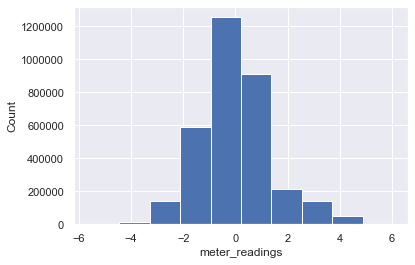

In [81]:
# Calculate the residuals
df['meter_residuals'] = df['meter_prediction'] - df['meter_reading']

# We will plot the histogram of the residuals first
residuals_hist = plt.hist(df.meter_residuals)

# Add axes labels
plt.xlabel('meter_readings')
plt.ylabel('Count')

# And we will print the statistical summary of the residuals,
df['meter_residuals'].describe()

The residuals do resemble a normal distribution with a mean and median very close to zero. The errors range from -6 to 6 (based on the maximum and minimum values), although for the most part we can clearly see that the vast majority of errors range from +/- 1. Overall, the residuals paint a much nicer picture of the model then the $R^2$ value in our summary suggests. We can obtain a pretty accurate prediction with this fit the majority of the time, although the goal is obviously to get as close to zero as possible.

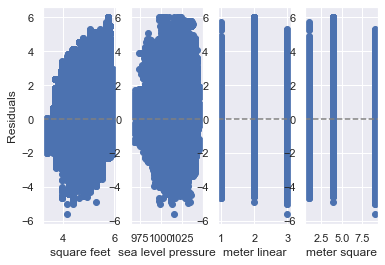

In [85]:
# Plotting the dependence between the residuals and individual variables
fig = plt.figure()

ax1 = fig.add_subplot(141)
ax1.plot(df.square_feet, df.meter_residuals, 'o')
ax1.axhline(y = 0, linestyle = '--', color = 'grey')
ax1.set_xlabel('square feet')
ax1.set_ylabel('Residuals')

ax2 = fig.add_subplot(142)
ax2.plot(df.sea_level_pressure, df.meter_residuals, 'o')
ax2.axhline(y = 0, linestyle = '--', color = 'grey')
ax2.set_xlabel('sea level pressure')

ax3 = fig.add_subplot(143)
ax3.plot(df.meter_linear, df.meter_residuals, 'o')
ax3.axhline(y = 0, linestyle = '--', color = 'grey')
ax3.set_xlabel('meter linear')

ax4 = fig.add_subplot(144)
ax4.plot(df.meter_square, df.meter_residuals, 'o')
ax4.axhline(y = 0, linestyle = '--', color = 'grey')
ax4.set_xlabel('meter square')

plt.show()

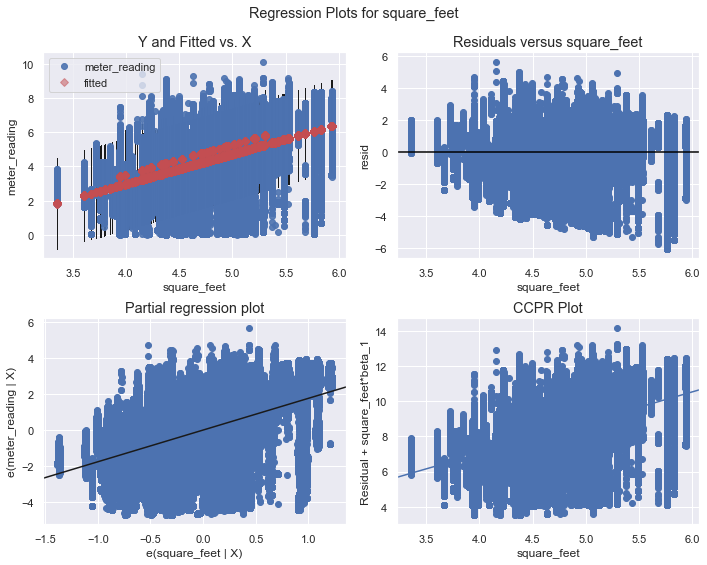

In [86]:
fig = plt.figure(figsize=(10,8))
fig = plot_regress_exog(model, "square_feet", fig = fig)

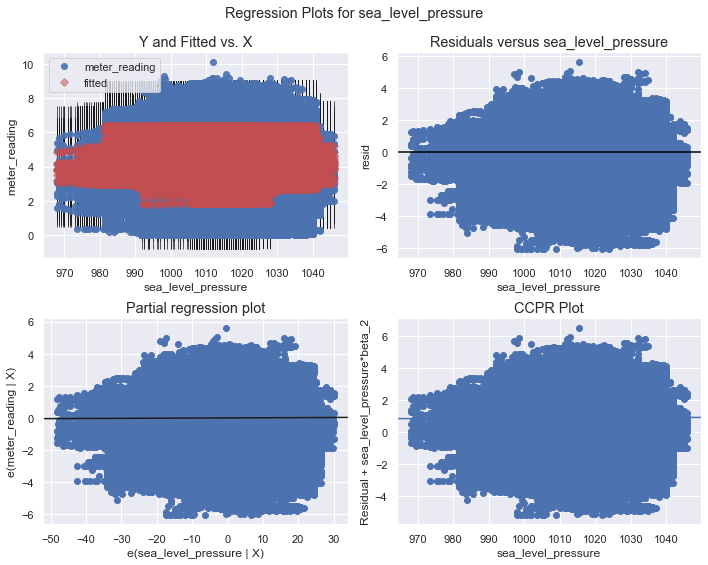

In [87]:
fig = plt.figure(figsize=(10,8))
fig = plot_regress_exog(model, "sea_level_pressure", fig = fig)

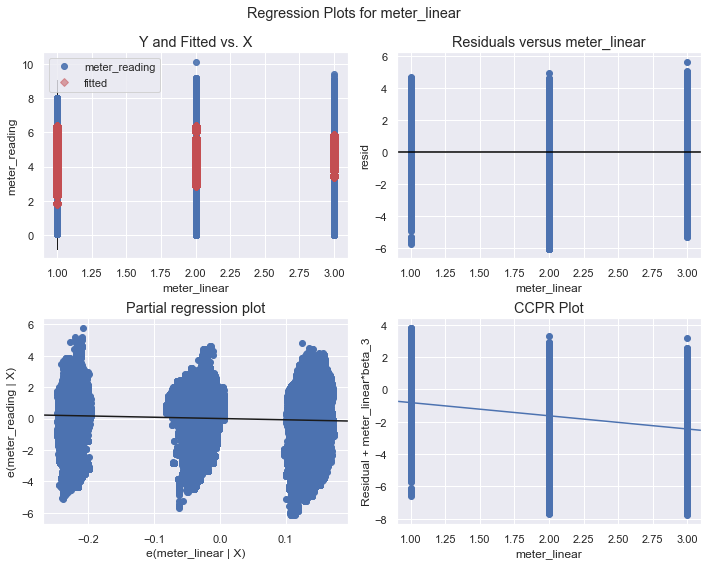

In [88]:
fig = plt.figure(figsize=(10,8))
fig = plot_regress_exog(model, "meter_linear", fig = fig)

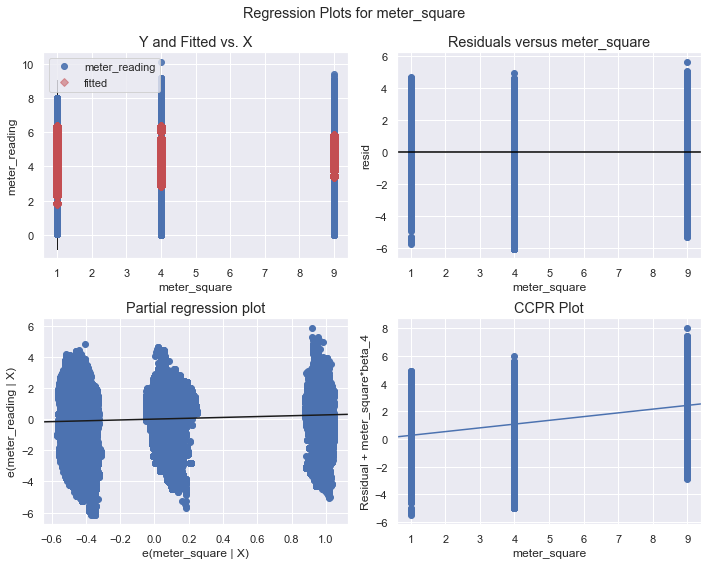

In [89]:
fig = plt.figure(figsize=(10,8))
fig = plot_regress_exog(model, "meter_square", fig = fig)

Our regression plots all seem to follow a similar pattern. We are hoping to see constant variability of the residuals throughout, but it appears that we observe an increase in variability as X increases. In other words, if X is small, then it is more likely we are going to have a more accurate prediction for our reposnse. Our goal is to find a model that isn't heavily influenced by the size of our predictor values.

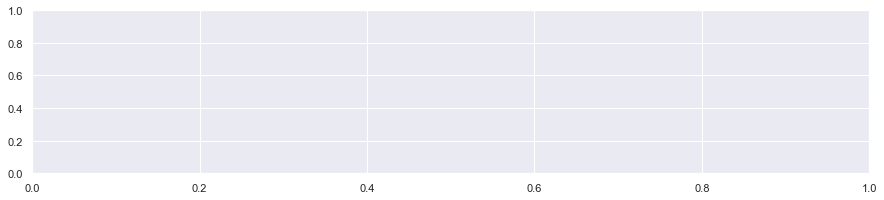

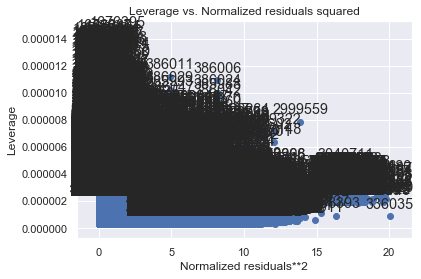

In [93]:
# Plot of the Leverage of the normalized residuals squared 
# Cannot get it to run, leaving code in if someone wants to make an attempt

fig, ax = plt.subplots(figsize=(15,3))
fig = plot_leverage_resid2(model_short, ax=ax)

In [ ]:
# Influence Plot for the model 
# Cannot get it to run, leaving code in if someone wants to make an attempt

#fig, ax = plt.subplots(figsize=(15,6))
#fig = influence_plot(model_short, ax=ax)

Calculating $R^2$, RMSE and NRMSE to assess the strength of our predictions:

In [92]:
# First we will calculate the R-squared

# Calculate correllation between predicted and actual values
pred_corr = df[['meter_reading', 'meter_prediction']].corr()

# Calculate the R-squared value
R2 = pred_corr.loc['meter_reading', 'meter_prediction']**2

# Calculate root mean square error (RMSE)
pred_rmse = rmse(df.meter_prediction, df.meter_reading)

# Normalize by the mean meter reading
pred_nrmse = pred_rmse / df.meter_reading.mean()

print ('R2 = %f' % R2)
print('RMSE = %f' % pred_rmse)
print('NRMSE = %f' % pred_nrmse)

R2 = 0.243694
RMSE = 1.358409
NRMSE = 0.313044


The obtained RMSE is approximately 1.36, which means that in average our predictions are off by 1.36, which is approximately 3.13% of the average meter reading in our dataset.